In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import siglib

Define Constants
---

In [2]:
from siglib import data_m

min_depth = 100; clonality = (0, 0.4); notation = 'pyrimidine'

EG10fasta_file = '/home/clint/essigmann_analysis/afb1_signature/data/EG10_corrected.fasta'
merfile = '/home/clint/essigmann_analysis/afb1_signature/data/EG10_slice_counts.jf'

Read in Trinucleotide Frequencies of Reference Genome
---

In [3]:
from jellywrap import Jellyfish, dna_notation

j = Jellyfish()
_ = j.read_mer_file(merfile)

Parse all Files
---

In [4]:
from siglib.mutpos import from_mutpos

results = {}
for age in data_m.keys():
    for treatment in sorted(data_m[age].keys()):
        results[str(age) + ' week ' + treatment] = {}
        for id, infile in sorted(data_m[age][treatment].items()):
            mutations = from_mutpos(infile, EG10fasta_file, clonality=clonality,
                                    notation=notation, min_depth=min_depth, verbose=False)
            results[str(age) + ' week ' + treatment][id] = mutations

In [5]:
from siglib.utils import Spectrum
from siglib.figures import spectrum_map
names = []
vectors1 = []

for treatment in sorted(results.keys()):
    if treatment == '72 week DMSO (Hepatocytes)':
        continue
    full_sum = Spectrum(notation=notation)
    samples = 0
    for id, mutations in results[treatment].items():
        samples += 1
        for mutation in set(mutations):
            full_sum[str(mutation.substitution), str(mutation.context)] += 1
    names.append(treatment)
    vectors1.append(full_sum.normalized_proportion(j.normal()))

Load Human Genome into Memory for Fast Random Access
---

In [6]:
from siglib.utils import fasta
hg38_path = '/home/clint/buffalo/hg38/hg38.fa'
hg38 = fasta(hg38_path)

In [7]:
from siglib.cosmic import parse_to_samples, merge_samples

cosmic_mutants = '/home/clint/buffalo/cosmic/v76/CosmicMutantExport_LiverHCC.tsv'
samples = merge_samples(parse_to_samples(cosmic_mutants))

In [8]:
for sample in samples.values():
    for mutation in sample.mutations:
        mutation.set_context(hg38, notation=notation)

In [9]:
humans = ['CHC1154T', 'CHC1211T', 'CHC1704T', 'CHC1717T', 'CHC1754T',
          'TCGA-CC-A5UE-01', 'TCGA-CC-A7IG-01', 'TCGA-CC-A7II-01', 'TCGA-CC-A7IL-01',
          'TCGA-DD-A114-01', 'TCGA-DD-A1EL-01']

cohort = []

for id, sample in sorted(samples.items()):
    if sample.name in humans:
        cohort.append(sample)

In [10]:
vectors2 = []
for sample in cohort:
    spectrum = Spectrum(notation=notation)
    for mutation in sample.mutations:
        spectrum[mutation.label[2:5], str(mutation.context)] += 1
    vectors2.append(spectrum.normalized_proportion(j.normal()))

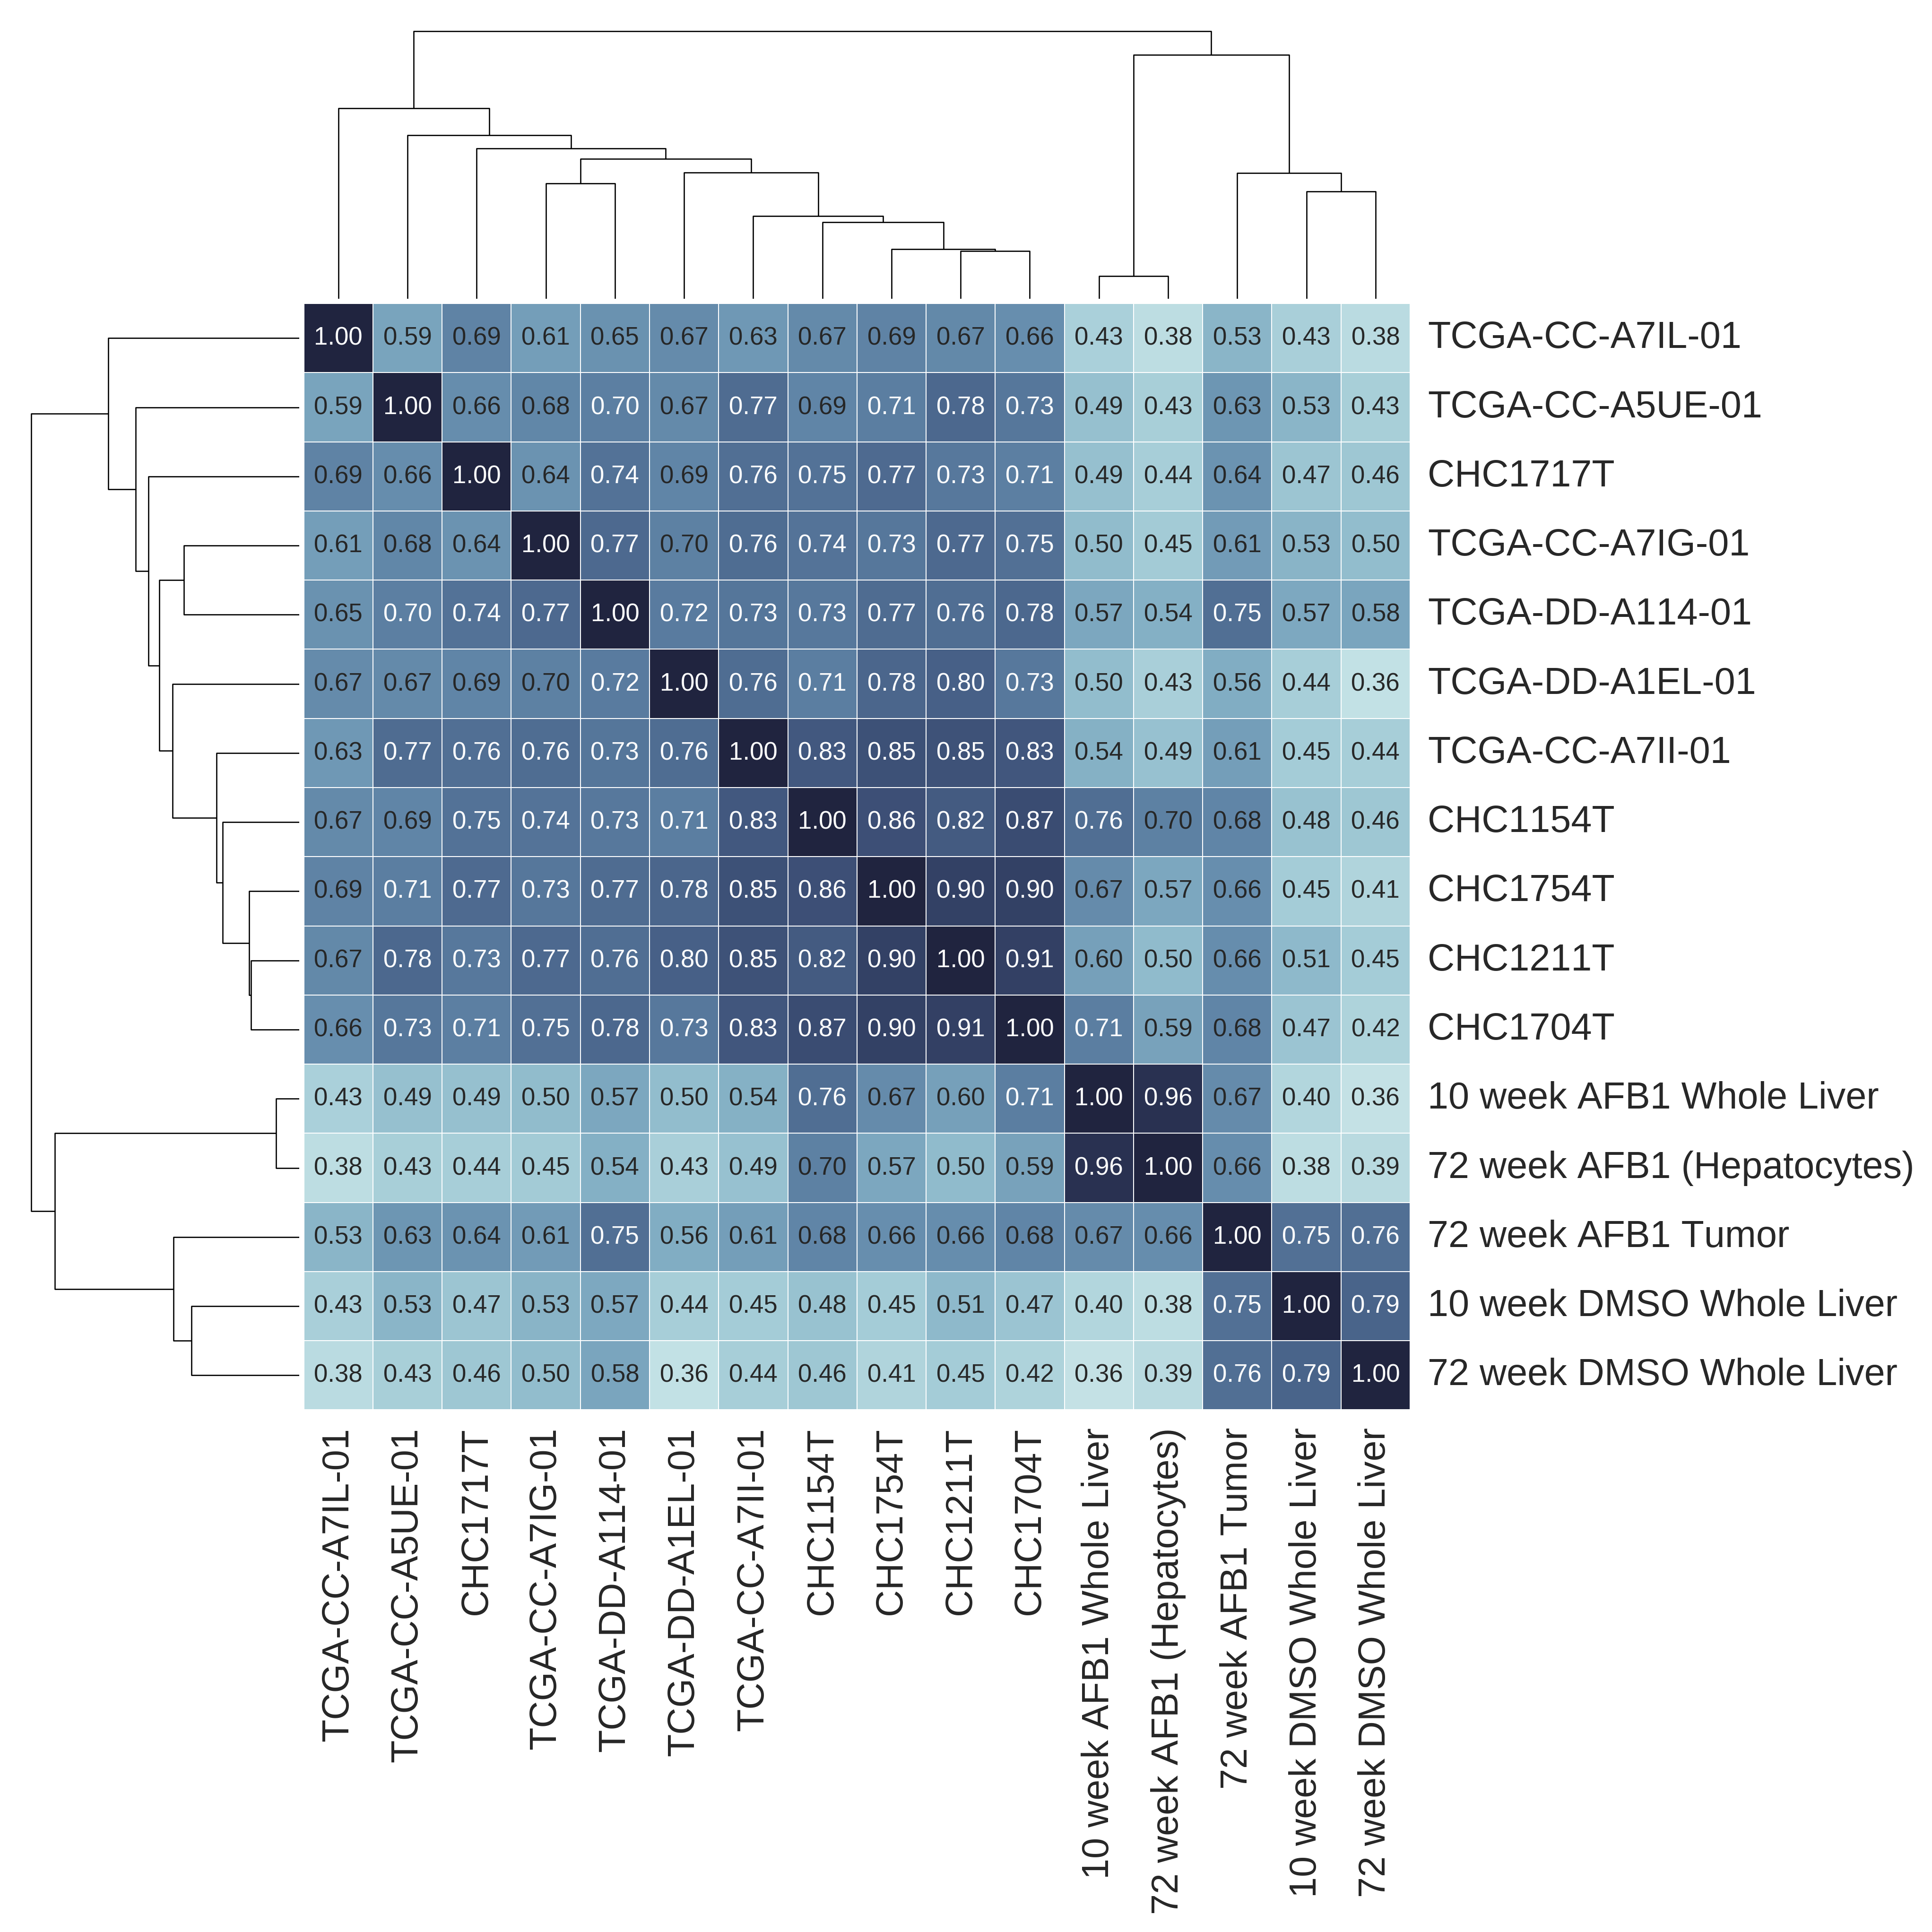

In [11]:
import matplotlib
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import cosine_similarity


labels = humans + names
vectors = vectors2 + vectors1

pdist = cosine_similarity(vectors)

distances = pd.DataFrame(pdist, columns=labels, index=labels)
linkages = linkage(vectors, method='weighted', metric='cosine')

grid = sns.clustermap(distances,
                      fmt='.2f',
                      method='weighted',
                      cmap=sns.cubehelix_palette(start=9, rot=-0.2, dark=0.15, light=.85, as_cmap=True),
                      annot=True,
                      row_linkage=linkages,
                      col_linkage=linkages,
                      row_cluster=True,
                      col_cluster=True,
                      linewidths=.2)

size = 15
_ = grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), size=size)
_ = grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), size=size, rotation=0)
grid.cax.remove()
for t in grid.ax_heatmap.texts:
    t.set_fontsize(10)
for l in grid.ax_row_dendrogram.lines:
        l.set_linewidth(10)
for l in grid.ax_col_dendrogram.lines:
        l.set_linewidth(100)
plt.savefig('cluster.pdf', dpi=450, bbox_inches='tight')

In [46]:
import csv

with open("vectors_samples.csv", "w") as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow([''] + list(spectrum.contexts))
    writer.writerow([''] + list(spectrum.sub_types))
    for i, vector in enumerate(vectors):
        row = [labels[i].replace(' ', '')] + vector
        writer.writerow(row)